In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
def detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02):
  drips = []
  for i in range(len(data) - min_window):
    # ข้าม drip ก่อนหน้า
    if drips and i < drips[-1]['end_index']:
      continue
    
    close_price = data['close'].iloc[i]
    low_price = data['low'].iloc[i:i+min_window].min()
    drip_pct = (low_price - close_price) / close_price
    
    # ตรวจสอบเงื่อนไขการลดลงมากกว่า 3%
    if drip_pct <= threshold:
      end_index = i + min_window - 1
      duration = end_index - i + 1
      
      for j in range(i, i+max_window):
        high = data['high'].iloc[j]
        low = data['low'].iloc[j]
        open_price = data['open'].iloc[j]
        close = data['close'].iloc[j]
        
        # คำนวณ high-to-low % และตรวจสอบว่า open-to-close เป็นบวก
        high_to_low_pct = (high - low) / low
        if (close > open_price) and (high_to_low_pct > increase_threshold):
          end_index = j
          duration = end_index - i + 1
          drip_pct = (low_price - close_price) / close_price
          break
      
      if duration >= min_window and duration <= max_window:
        drips.append({
          'start_time': data.index[i],
          'close_price': close_price,
          'low_price': low_price,
          'drip_pct': drip_pct * 100,  # แปลงเป็น %
          'end_index': end_index,
          'duration': duration
        })
        
  
  return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/1h/BTCUSDT.pkl"))
data = data["2021-01-01":]
drips = detect_drip(data, min_window=6, max_window=48, threshold=-0.03, increase_threshold=0.02)

Monthly Drip Summary:
    Month  Number of Drips  Mean Drip Size (%)  Std Drip Size (%)
  January               60           -4.056348           1.289806
 February               44           -3.786845           0.910428
    March               56           -3.719052           0.861494
    April               48           -3.682907           0.830175
      May               44           -4.360863           1.541619
     June               50           -3.992004           1.028259
     July               34           -3.718806           0.709338
   August               32           -4.060809           1.476922
September               20           -4.343285           1.548983
  October               19           -3.690040           0.800428
 November               31           -3.811732           0.871046
 December               26           -3.709307           0.970304


/tmp/ipykernel_41262/10550242.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Number of Drips', data=monthly_summary, palette='Blues_d')


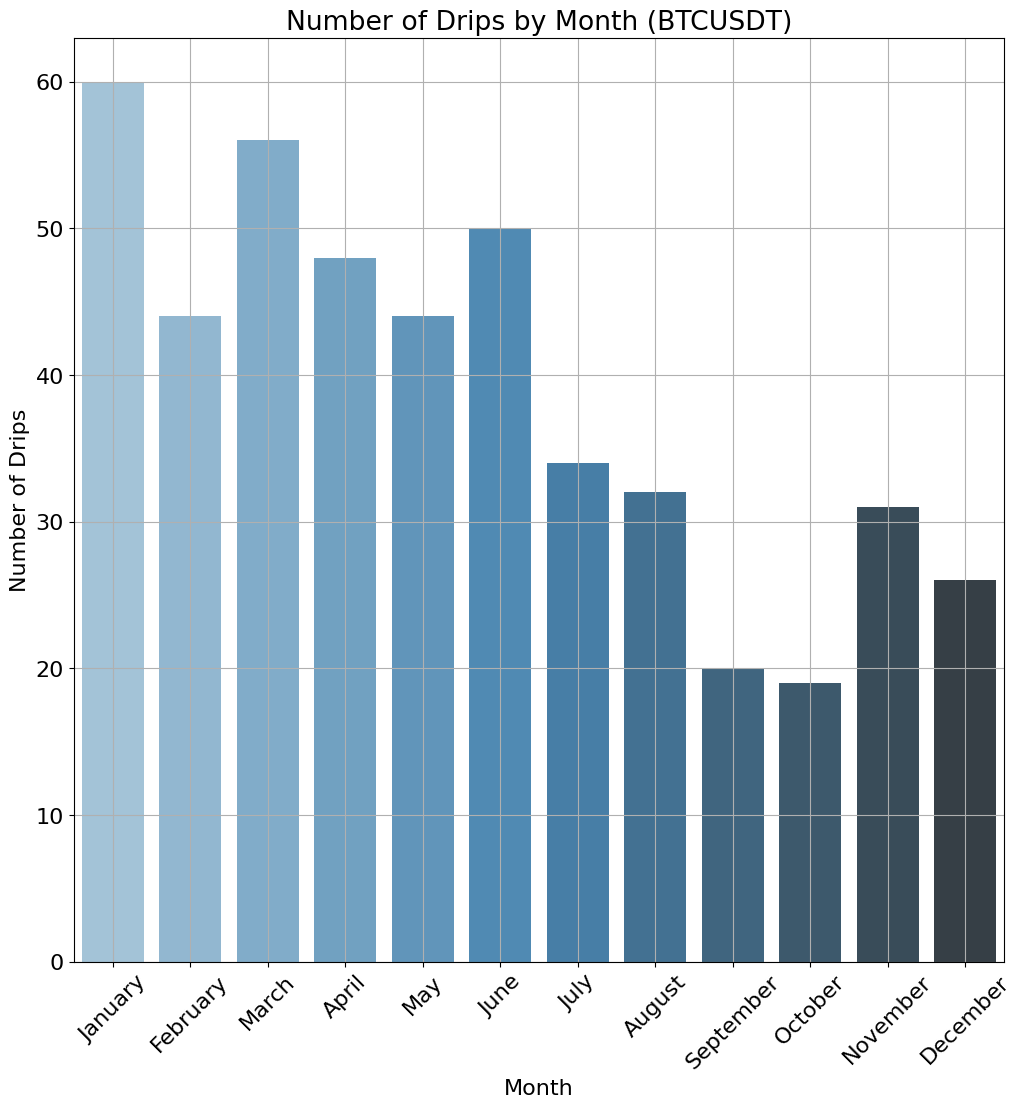

/tmp/ipykernel_41262/10550242.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Mean Drip Size (%)', data=monthly_summary, palette='Reds_d')


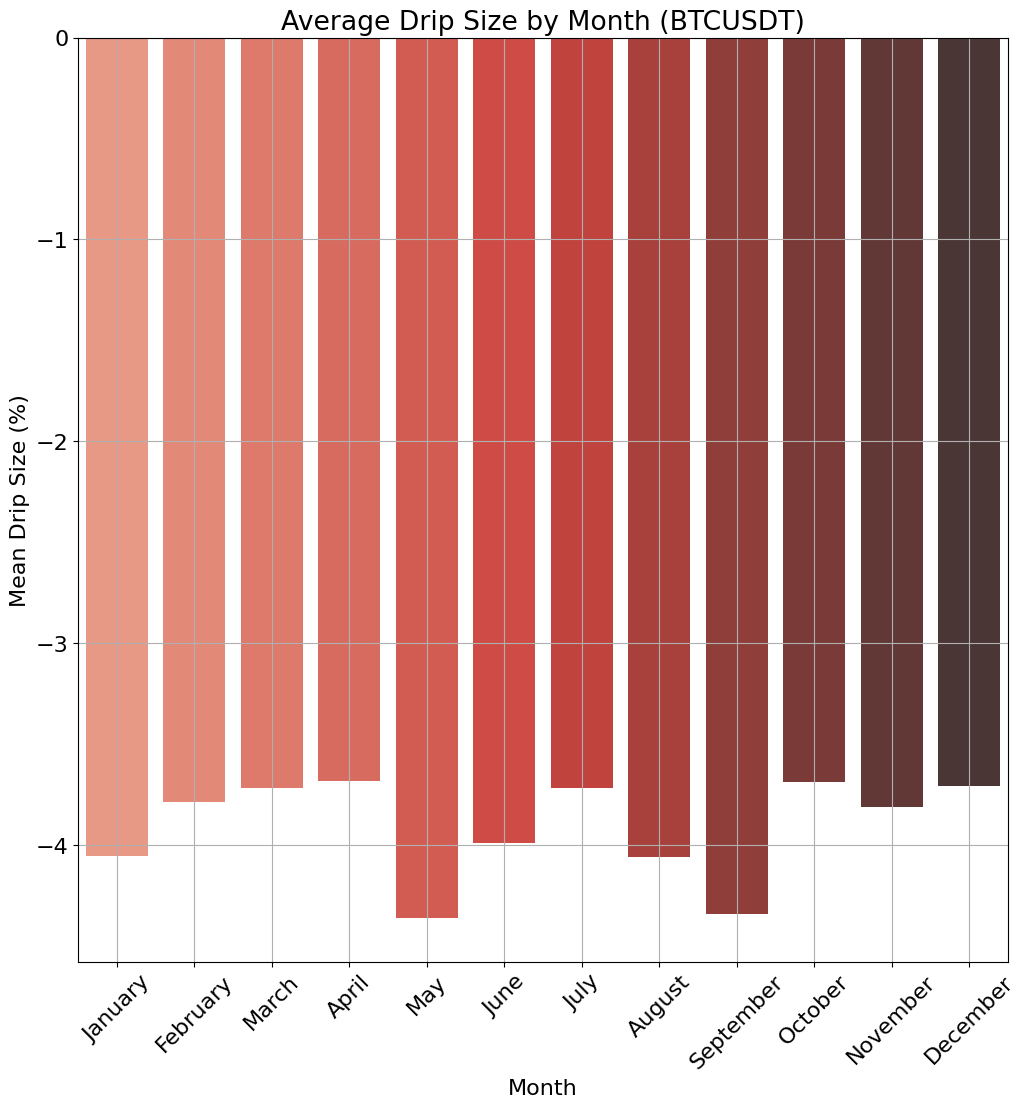

/tmp/ipykernel_41262/10550242.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='drip_pct', data=drips, palette='Set2', order=month_order)


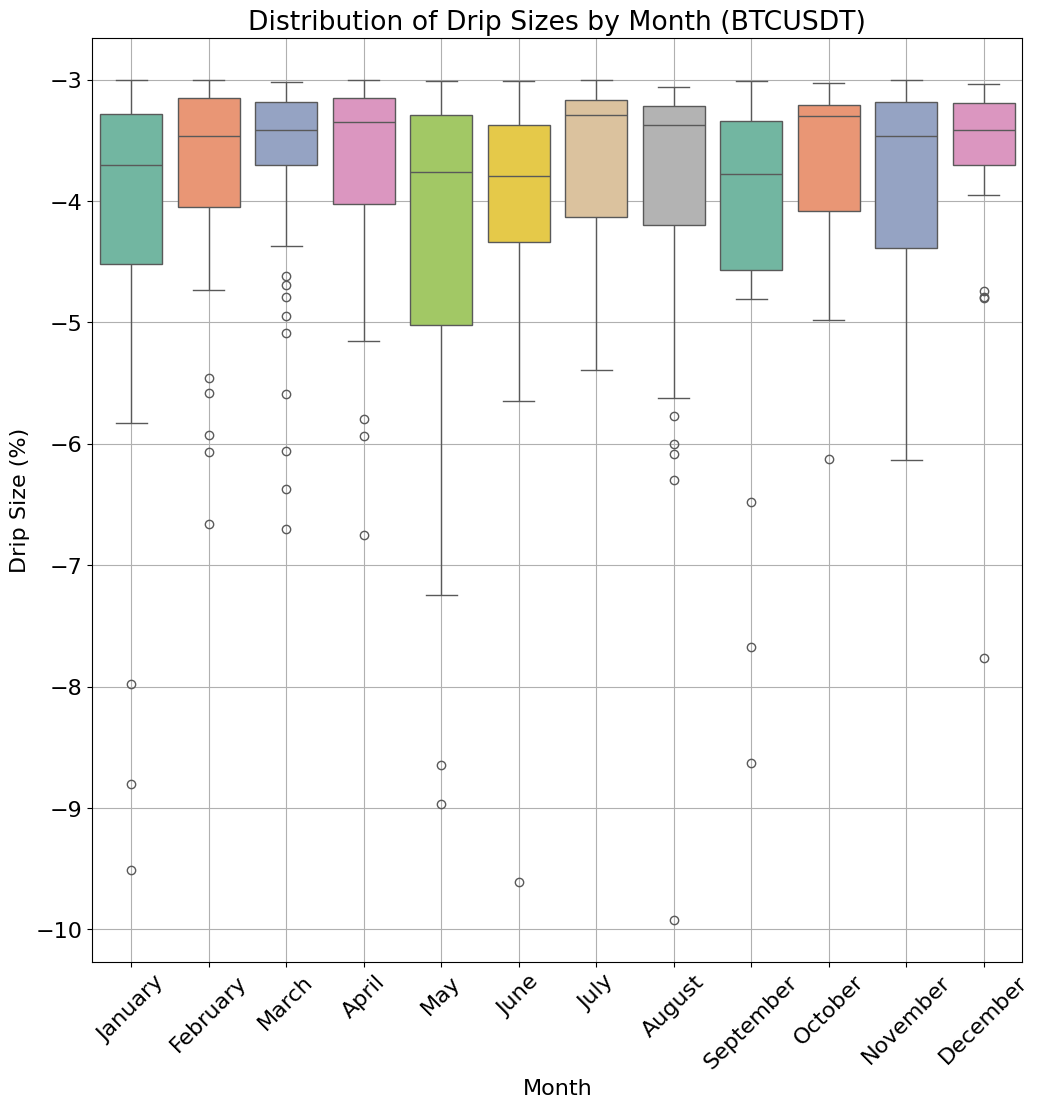

In [5]:
# สร้างคอลัมน์ 'month' จาก start_time
drips['month'] = drips['start_time'].dt.month_name()

# สรุปจำนวน Drip และขนาดเฉลี่ยตามเดือน
monthly_summary = drips.groupby('month').agg({
    'drip_pct': ['count', 'mean', 'std'],
}).reset_index()

# เปลี่ยนชื่อคอลัมน์ให้เข้าใจง่าย
monthly_summary.columns = ['Month', 'Number of Drips', 'Mean Drip Size (%)', 'Std Drip Size (%)']

# จัดเรียงเดือนตามลำดับปฏิทิน
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_summary['Month'] = pd.Categorical(monthly_summary['Month'], categories=month_order, ordered=True)
monthly_summary = monthly_summary.sort_values('Month')

# แสดงตารางสรุป
print("Monthly Drip Summary:")
print(monthly_summary.to_string(index=False))

# กราฟแท่งแสดงจำนวน Drip ในแต่ละเดือน
plt.figure(figsize=(12, 12))
sns.barplot(x='Month', y='Number of Drips', data=monthly_summary, palette='Blues_d')
plt.title('Number of Drips by Month (BTCUSDT)')
plt.xlabel('Month')
plt.ylabel('Number of Drips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# กราฟแท่งแสดงขนาด Drip เฉลี่ยในแต่ละเดือน
plt.figure(figsize=(12, 12))
sns.barplot(x='Month', y='Mean Drip Size (%)', data=monthly_summary, palette='Reds_d')
plt.title('Average Drip Size by Month (BTCUSDT)')
plt.xlabel('Month')
plt.ylabel('Mean Drip Size (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Boxplot แสดงการกระจายของขนาด Drip ในแต่ละเดือน
plt.figure(figsize=(12, 12))
sns.boxplot(x='month', y='drip_pct', data=drips, palette='Set2', order=month_order)
plt.title('Distribution of Drip Sizes by Month (BTCUSDT)')
plt.xlabel('Month')
plt.ylabel('Drip Size (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()